# TensorFlow Tutorial #18
# TFRecords & Dataset API

by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)
/ [GitHub](https://github.com/Hvass-Labs/TensorFlow-Tutorials) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmEu1ZniY0XpHSzl5uihcXZ)

## Introduction

In the previous tutorials we used a so-called feed-dict for inputting data to the TensorFlow graph. It is a fairly simple input method but it is also a performance bottleneck because the data is read sequentially between training steps. This makes it hard to use the GPU at 100% efficiency because the GPU has to wait for new data to work on.

Instead we want to read data in a parallel thread so new training data is always available whenever the GPU is ready. This used to be done with so-called QueueRunners in TensorFlow which was a very complicated system. Now it can be done with the Dataset API and a binary file-format called TFRecords, as described in this tutorial.

This builds on Tutorial #17 for the Estimator API.

## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.image import imread
import tensorflow as tf
import numpy as np
import sys
import os

This was developed using Python 3.6 (Anaconda) and TensorFlow version:

In [2]:
tf.__version__

'1.12.0'

## Load Data

In [3]:
import knifey

The data dimensions have already been defined in the `knifey` module, so we just need to import the ones we need.

In [4]:
from knifey import img_size, img_size_flat, img_shape, num_classes, num_channels

Set the directory for storing the data-set on your computer.

In [5]:
# knifey.data_dir = "data/knifey-spoony/"

The Knifey-Spoony data-set is about 22 MB and will be downloaded automatically if it is not located in the given path.

In [6]:
knifey.maybe_download_and_extract()

Data has apparently already been downloaded and unpacked.


Now load the data-set. This scans the sub-directories for all `*.jpg` images and puts the filenames into two lists for the training-set and test-set. This does not actually load the images.

In [7]:
dataset = knifey.load()

Creating dataset from the files in: data/knifey-spoony/
- Data loaded from cache-file: data/knifey-spoony/knifey-spoony.pkl


Get the class-names.

In [8]:
class_names = dataset.class_names
class_names

['forky', 'knifey', 'spoony']

### Training and Test-Sets

This function returns the file-paths for the images, the class-numbers as integers, and the class-numbers as One-Hot encoded arrays called labels.

In this tutorial we will actually use the integer class-numbers and call them labels. This may be a little confusing but you can always add print-statements to see what the data actually is.

In [9]:
image_paths_train, cls_train, labels_train = dataset.get_training_set()

Print the first image-path to see if it looks OK.

In [10]:
image_paths_train[0]

'/home/mao/workspace/TensorFlow-Tutorials/data/knifey-spoony/forky/forky-01-0241.jpg'

Get the test-set.

In [11]:
image_paths_test, cls_test, labels_test = dataset.get_test_set()

Print the first image-path to see if it looks OK.

In [12]:
image_paths_test[0]

'/home/mao/workspace/TensorFlow-Tutorials/data/knifey-spoony/forky/test/forky-test-01-0053.jpg'

The Knifey-Spoony data-set has now been loaded and consists of 4700 images and associated labels (i.e. classifications of the images). The data-set is split into 2 mutually exclusive sub-sets, the training-set and the test-set.

In [13]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(image_paths_train)))
print("- Test-set:\t\t{}".format(len(image_paths_test)))

Size of:
- Training-set:		4170
- Test-set:		530


### Helper-function for plotting images

Function used to plot 9 images in a 3x3 grid, and writing the true and predicted classes below each image.

In [14]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true)

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    for i, ax in enumerate(axes.flat):
        # There may be less than 9 images, ensure it doesn't crash.
        if i < len(images):
            # Plot image.
            ax.imshow(images[i],
                      interpolation=interpolation)

            # Name of the true class.
            cls_true_name = class_names[cls_true[i]]

            # Show true and predicted classes.
            if cls_pred is None:
                xlabel = "True: {0}".format(cls_true_name)
            else:
                # Name of the predicted class.
                cls_pred_name = class_names[cls_pred[i]]

                xlabel = "True: {0}\nPred: {1}".format(cls_true_name,
                                                       cls_pred_name)

            # Show the classes as the label on the x-axis.
            ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Helper-function for loading images

This dataset does not load the actual images, instead it has a list of the images in the training-set and another list for the images in the test-set. This helper-function loads some image-files.

In [15]:
def load_images(image_paths):
    # Load the images from disk.
    images = [imread(path) for path in image_paths]

    # Convert to a numpy array and return it.
    return np.asarray(images)

### Plot a few images to see if data is correct

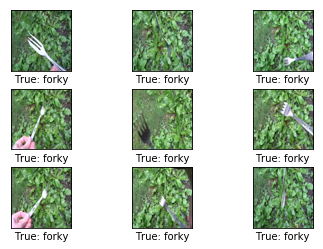

In [16]:
# Load the first images from the test-set.
images = load_images(image_paths=image_paths_test[0:9])

# Get the true classes for those images.
cls_true = cls_test[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true, smooth=True)

## Create TFRecords

TFRecords is the binary file-format used internally in TensorFlow which allows for high-performance reading and processing of datasets.

For this small dataset we will just create one TFRecords file for the training-set and another for the test-set. But if your dataset is very large then you can split it into several TFRecords files called shards. This will also improve the random shuffling, because the Dataset API only shuffles from a smaller buffer of e.g. 1024 elements loaded into RAM. So if you have e.g. 100 TFRecords files, then the randomization will be much better than for a single TFRecords file.

File-path for the TFRecords file holding the training-set.

In [17]:
path_tfrecords_train = os.path.join(knifey.data_dir, "train.tfrecords")
path_tfrecords_train

'data/knifey-spoony/train.tfrecords'

File-path for the TFRecords file holding the test-set.

In [18]:
path_tfrecords_test = os.path.join(knifey.data_dir, "test.tfrecords")
path_tfrecords_test

'data/knifey-spoony/test.tfrecords'

Helper-function for printing the conversion progress.

In [19]:
def print_progress(count, total):
    # Percentage completion.
    pct_complete = float(count) / total

    # Status-message.
    # Note the \r which means the line should overwrite itself.
    msg = "\r- Progress: {0:.1%}".format(pct_complete)

    # Print it.
    sys.stdout.write(msg)
    sys.stdout.flush()

Helper-function for wrapping an integer so it can be saved to the TFRecords file.

In [20]:
def wrap_int64(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

Helper-function for wrapping raw bytes so they can be saved to the TFRecords file.

In [21]:
def wrap_bytes(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

This is the function for reading images from disk and writing them along with the class-labels to a TFRecords file. This loads and decodes the images to numpy-arrays and then stores the raw bytes in the TFRecords file. If the original image-files are compressed e.g. as jpeg-files, then the TFRecords file may be many times larger than the original image-files.

It is also possible to save the compressed image files directly in the TFRecords file because it can hold any raw bytes. We would then have to decode the compressed images when the TFRecords file is being read later in the `parse()` function below.

In [22]:
def convert(image_paths, labels, out_path):
    # Args:
    # image_paths   List of file-paths for the images.
    # labels        Class-labels for the images.
    # out_path      File-path for the TFRecords output file.
    
    print("Converting: " + out_path)
    
    # Number of images. Used when printing the progress.
    num_images = len(image_paths)
    
    # Open a TFRecordWriter for the output-file.
    with tf.python_io.TFRecordWriter(out_path) as writer:
        
        # Iterate over all the image-paths and class-labels.
        for i, (path, label) in enumerate(zip(image_paths, labels)):
            # Print the percentage-progress.
            print_progress(count=i, total=num_images-1)

            # Load the image-file using matplotlib's imread function.
            img = imread(path)
            
            # Convert the image to raw bytes.
            img_bytes = img.tostring()

            # Create a dict with the data we want to save in the
            # TFRecords file. You can add more relevant data here.
            data = \
                {
                    'image': wrap_bytes(img_bytes),
                    'label': wrap_int64(label)
                }

            # Wrap the data as TensorFlow Features.
            feature = tf.train.Features(feature=data)

            # Wrap again as a TensorFlow Example.
            example = tf.train.Example(features=feature)

            # Serialize the data.
            serialized = example.SerializeToString()
            
            # Write the serialized data to the TFRecords file.
            writer.write(serialized)

Note the 4 function calls required to write the data-dict to the TFRecords file. In the original code-example from the Google Developers, these 4 function calls were actually nested. The design-philosophy for TensorFlow generally seems to be: If one function call is good, then 4 function calls are 4 times as good, and if they are nested then it is exponential goodness!

Of course, this is quite poor API design because the last function `writer.write()` should just be able to take the data-dict directly and then call the 3 other functions internally.

Convert the training-set to a TFRecords-file. Note how we use the integer class-numbers as the labels instead of the One-Hot encoded arrays.

In [23]:
convert(image_paths=image_paths_train,
        labels=cls_train,
        out_path=path_tfrecords_train)

Converting: data/knifey-spoony/train.tfrecords
- Progress: 100.0%

Convert the test-set to a TFRecords-file:

In [24]:
convert(image_paths=image_paths_test,
        labels=cls_test,
        out_path=path_tfrecords_test)

Converting: data/knifey-spoony/test.tfrecords
- Progress: 100.0%

## Input Functions for the Estimator

The TFRecords files contain the data in a serialized binary format which needs to be converted back to images and labels of the correct data-type. We use a helper-function for this parsing:

In [25]:
def parse(serialized):
    # Define a dict with the data-names and types we expect to
    # find in the TFRecords file.
    # It is a bit awkward that this needs to be specified again,
    # because it could have been written in the header of the
    # TFRecords file instead.
    features = \
        {
            'image': tf.FixedLenFeature([], tf.string),
            'label': tf.FixedLenFeature([], tf.int64)
        }

    # Parse the serialized data so we get a dict with our data.
    parsed_example = tf.parse_single_example(serialized=serialized,
                                             features=features)

    # Get the image as raw bytes.
    image_raw = parsed_example['image']

    # Decode the raw bytes so it becomes a tensor with type.
    image = tf.decode_raw(image_raw, tf.uint8)
    
    # The type is now uint8 but we need it to be float.
    image = tf.cast(image, tf.float32)

    # Get the label associated with the image.
    label = parsed_example['label']

    # The image and label are now correct TensorFlow types.
    return image, label

Helper-function for creating an input-function that reads from TFRecords files for use with the Estimator API.

In [26]:
def input_fn(filenames, train, batch_size=32, buffer_size=2048):
    # Args:
    # filenames:   Filenames for the TFRecords files.
    # train:       Boolean whether training (True) or testing (False).
    # batch_size:  Return batches of this size.
    # buffer_size: Read buffers of this size. The random shuffling
    #              is done on the buffer, so it must be big enough.

    # Create a TensorFlow Dataset-object which has functionality
    # for reading and shuffling data from TFRecords files.
    dataset = tf.data.TFRecordDataset(filenames=filenames)

    # Parse the serialized data in the TFRecords files.
    # This returns TensorFlow tensors for the image and labels.
    dataset = dataset.map(parse)

    if train:
        # If training then read a buffer of the given size and
        # randomly shuffle it.
        dataset = dataset.shuffle(buffer_size=buffer_size)

        # Allow infinite reading of the data.
        num_repeat = None
    else:
        # If testing then don't shuffle the data.
        
        # Only go through the data once.
        num_repeat = 1

    # Repeat the dataset the given number of times.
    dataset = dataset.repeat(num_repeat)
    
    # Get a batch of data with the given size.
    dataset = dataset.batch(batch_size)

    # Create an iterator for the dataset and the above modifications.
    iterator = dataset.make_one_shot_iterator()

    # Get the next batch of images and labels.
    images_batch, labels_batch = iterator.get_next()

    # The input-function must return a dict wrapping the images.
    x = {'image': images_batch}
    y = labels_batch

    return x, y

In [51]:
x,y=input_fn(filenames=path_tfrecords_train, train=True)

In [54]:
init=tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    a=sess.run(y)
    print(y)

Tensor("IteratorGetNext_4:1", shape=(?,), dtype=int64)


This is the input-function for the training-set for use with the Estimator API:

In [27]:
def train_input_fn():
    return input_fn(filenames=path_tfrecords_train, train=True)

This is the input-function for the test-set for use with the Estimator API:

In [28]:
def test_input_fn():
    return input_fn(filenames=path_tfrecords_test, train=False)

### Input Function for Predicting on New Images

An input-function is also needed for predicting the class of new data. As an example we just use a few images from the test-set.

You could load any images you want here. Make sure they are the same dimensions as expected by the TensorFlow model, otherwise you need to resize the images.

In [29]:
some_images = load_images(image_paths=image_paths_test[0:9])

These images are now stored as numpy arrays in memory, so we can use the standard input-function for the Estimator API. Note that the images are loaded as uint8 data but it must be input to the TensorFlow graph as floats so we do a type-cast.

In [30]:
predict_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"image": some_images.astype(np.float32)},
    num_epochs=1,
    shuffle=False)

The class-numbers are actually not used in the input-function as it is not needed for prediction. However, the true class-number is needed when we plot the images further below.

In [31]:
some_images_cls = cls_test[0:9]

## Pre-Made / Canned Estimator

When using a pre-made Estimator, we need to specify the input features for the data. In this case we want to input images from our data-set which are numeric arrays of the given shape.

In [32]:
feature_image = tf.feature_column.numeric_column("image",
                                                 shape=img_shape)

You can have several input features which would then be combined in a list:

In [33]:
feature_columns = [feature_image]

In this example we want to use a 3-layer DNN with 512, 256 and 128 units respectively.

In [34]:
num_hidden_units = [512, 256, 128]

The `DNNClassifier` then constructs the neural network for us. We can also specify the activation function and various other parameters (see the docs). Here we just specify the number of classes and the directory where the checkpoints will be saved.

In [35]:
model = tf.estimator.DNNClassifier(feature_columns=feature_columns,
                                   hidden_units=num_hidden_units,
                                   activation_fn=tf.nn.relu,
                                   n_classes=num_classes,
                                   model_dir="./checkpoints_tutorial18-1/")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './checkpoints_tutorial18-1/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f78285462e8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


### Training

We can now train the model for a given number of iterations. This automatically loads and saves checkpoints so we can continue the training later.

In [36]:
model.train(input_fn=train_input_fn, steps=200)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into ./checkpoints_tutorial18-1/model.ckpt.
INFO:tensorflow:loss = 1252.175, step = 1
INFO:tensorflow:global_step/sec: 4.11307
INFO:tensorflow:loss = 31.860073, step = 101 (24.314 sec)
INFO:tensorflow:Saving checkpoints for 200 into ./checkpoints_tutorial18-1/model.ckpt.
INFO:tensorflow:Loss for final step: 35.028008.


### Evaluation

Once the model has been trained, we can evaluate its performance on the test-set.

In [37]:
result = model.evaluate(input_fn=test_input_fn)

INFO:tensorflow:Starting evaluation at 2017-11-25-09:31:37
INFO:tensorflow:Restoring parameters from ./checkpoints_tutorial18-1/model.ckpt-200
INFO:tensorflow:Finished evaluation at 2017-11-25-09:31:38
INFO:tensorflow:Saving dict for global step 200: accuracy = 0.456604, average_loss = 1.07088, global_step = 200, loss = 33.3863


In [38]:
result

{'accuracy': 0.45660377,
 'average_loss': 1.0708818,
 'global_step': 200,
 'loss': 33.386318}

In [39]:
print("Classification accuracy: {0:.2%}".format(result["accuracy"]))

Classification accuracy: 45.66%


### Predictions

The trained model can also be used to make predictions on new data.

Note that the TensorFlow graph is recreated and the checkpoint is reloaded every time we make predictions on new data. If the model is very large then this could add a significant overhead.

It is unclear why the Estimator is designed this way, possibly because it will always use the latest checkpoint and it can also be distributed easily for use on multiple computers.

In [40]:
predictions = model.predict(input_fn=predict_input_fn)

In [41]:
cls = [p['classes'] for p in predictions]

INFO:tensorflow:Restoring parameters from ./checkpoints_tutorial18-1/model.ckpt-200


In [42]:
cls_pred = np.array(cls, dtype='int').squeeze()
cls_pred

array([2, 2, 2, 2, 2, 2, 2, 2, 2])

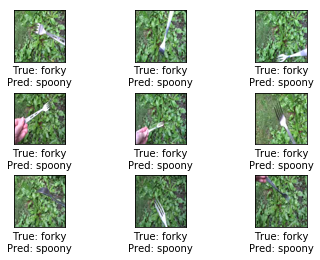

In [43]:
plot_images(images=some_images,
            cls_true=some_images_cls,
            cls_pred=cls_pred)

### Predictions for the Entire Test-Set

It appears that the model maybe classifies all images as 'spoony'. So let us see the predictions for the entire test-set. We can do this simply by using its input-function:

In [44]:
predictions = model.predict(input_fn=test_input_fn)

In [45]:
cls = [p['classes'] for p in predictions]

INFO:tensorflow:Restoring parameters from ./checkpoints_tutorial18-1/model.ckpt-200


In [46]:
cls_pred = np.array(cls, dtype='int').squeeze()

The test-set contains 530 images in total and they have all been predicted as class 2 (spoony). So this model does not work at all for classifying the Knifey-Spoony dataset.

In [47]:
np.sum(cls_pred == 2)

530

# New Estimator

If you cannot use one of the built-in Estimators, then you can create an arbitrary TensorFlow model yourself. To do this, you first need to create a function which defines the following:

1. The TensorFlow model, e.g. a Convolutional Neural Network.
2. The output of the model.
3. The loss-function used to improve the model during optimization.
4. The optimization method.
5. Performance metrics.

The Estimator can be run in three modes: Training, Evaluation, or Prediction. The code is mostly the same, but in Prediction-mode we do not need to setup the loss-function and optimizer.

This is another aspect of the Estimator API that is poorly designed and resembles how we did ANSI C programming using structs in the old days. It would probably have been more elegant to split this into several functions and sub-classed the Estimator-class.

In [48]:
def model_fn(features, labels, mode, params):
    # Args:
    #
    # features: This is the x-arg from the input_fn.
    # labels:   This is the y-arg from the input_fn.
    # mode:     Either TRAIN, EVAL, or PREDICT
    # params:   User-defined hyper-parameters, e.g. learning-rate.
    
    # Reference to the tensor named "image" in the input-function.
    x = features["image"]

    # The convolutional layers expect 4-rank tensors
    # but x is a 2-rank tensor, so reshape it.
    net = tf.reshape(x, [-1, img_size, img_size, num_channels])    

    # First convolutional layer.
    net = tf.layers.conv2d(inputs=net, name='layer_conv1',
                           filters=32, kernel_size=3,
                           padding='same', activation=tf.nn.relu)
    net = tf.layers.max_pooling2d(inputs=net, pool_size=2, strides=2)

    # Second convolutional layer.
    net = tf.layers.conv2d(inputs=net, name='layer_conv2',
                           filters=32, kernel_size=3,
                           padding='same', activation=tf.nn.relu)
    net = tf.layers.max_pooling2d(inputs=net, pool_size=2, strides=2)    

    # Flatten to a 2-rank tensor.
    net = tf.contrib.layers.flatten(net)
    # Eventually this should be replaced with:
    # net = tf.layers.flatten(net)

    # First fully-connected / dense layer.
    # This uses the ReLU activation function.
    net = tf.layers.dense(inputs=net, name='layer_fc1',
                          units=128, activation=tf.nn.relu)    

    # Second fully-connected / dense layer.
    # This is the last layer so it does not use an activation function.
    net = tf.layers.dense(inputs=net, name='layer_fc_2',
                          units=num_classes)

    # Logits output of the neural network.
    logits = net

    # Softmax output of the neural network.
    y_pred = tf.nn.softmax(logits=logits)
    
    # Classification output of the neural network.
    y_pred_cls = tf.argmax(y_pred, axis=1)

    if mode == tf.estimator.ModeKeys.PREDICT:
        # If the estimator is supposed to be in prediction-mode
        # then use the predicted class-number that is output by
        # the neural network. Optimization etc. is not needed.
        spec = tf.estimator.EstimatorSpec(mode=mode,
                                          predictions=y_pred_cls)
    else:
        # Otherwise the estimator is supposed to be in either
        # training or evaluation-mode. Note that the loss-function
        # is also required in Evaluation mode.
        
        # Define the loss-function to be optimized, by first
        # calculating the cross-entropy between the output of
        # the neural network and the true labels for the input data.
        # This gives the cross-entropy for each image in the batch.
        cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels,
                                                                       logits=logits)

        # Reduce the cross-entropy batch-tensor to a single number
        # which can be used in optimization of the neural network.
        loss = tf.reduce_mean(cross_entropy)

        # Define the optimizer for improving the neural network.
        optimizer = tf.train.AdamOptimizer(learning_rate=params["learning_rate"])

        # Get the TensorFlow op for doing a single optimization step.
        train_op = optimizer.minimize(
            loss=loss, global_step=tf.train.get_global_step())

        # Define the evaluation metrics,
        # in this case the classification accuracy.
        metrics = \
        {
            "accuracy": tf.metrics.accuracy(labels, y_pred_cls)
        }

        # Wrap all of this in an EstimatorSpec.
        spec = tf.estimator.EstimatorSpec(
            mode=mode,
            loss=loss,
            train_op=train_op,
            eval_metric_ops=metrics)
        
    return spec

### Create an Instance of the Estimator

We can specify hyper-parameters e.g. for the learning-rate of the optimizer.

In [49]:
params = {"learning_rate": 1e-4}

We can then create an instance of the new Estimator.

Note that we don't provide feature-columns here as it is inferred automatically from the data-functions when `model_fn()` is called.

It is unclear from the TensorFlow documentation why it is necessary to specify the feature-columns when using `DNNClassifier` in the example above, when it is not needed here.

In [50]:
model = tf.estimator.Estimator(model_fn=model_fn,
                               params=params,
                               model_dir="./checkpoints_tutorial18-2/")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './checkpoints_tutorial18-2/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fe80a0fbe80>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


### Training

Now that our new Estimator has been created, we can train it.

In [51]:
model.train(input_fn=train_input_fn, steps=200)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into ./checkpoints_tutorial18-2/model.ckpt.
INFO:tensorflow:loss = 29.6568, step = 1
INFO:tensorflow:global_step/sec: 15.1419
INFO:tensorflow:loss = 20.0903, step = 101 (6.605 sec)
INFO:tensorflow:Saving checkpoints for 200 into ./checkpoints_tutorial18-2/model.ckpt.
INFO:tensorflow:Loss for final step: 3.11824.


### Evaluation

Once the model has been trained, we can evaluate its performance on the test-set.

In [52]:
result = model.evaluate(input_fn=test_input_fn)

INFO:tensorflow:Starting evaluation at 2017-11-25-09:32:03
INFO:tensorflow:Restoring parameters from ./checkpoints_tutorial18-2/model.ckpt-200
INFO:tensorflow:Finished evaluation at 2017-11-25-09:32:04
INFO:tensorflow:Saving dict for global step 200: accuracy = 0.390566, global_step = 200, loss = 6.8253


In [53]:
result

{'accuracy': 0.39056605, 'global_step': 200, 'loss': 6.8253026}

In [54]:
print("Classification accuracy: {0:.2%}".format(result["accuracy"]))

Classification accuracy: 39.06%


### Predictions

The model can also be used to make predictions on new data.

In [55]:
predictions = model.predict(input_fn=predict_input_fn)

In [56]:
cls_pred = np.array(list(predictions))
cls_pred

INFO:tensorflow:Restoring parameters from ./checkpoints_tutorial18-2/model.ckpt-200


array([0, 0, 0, 0, 0, 0, 0, 0, 0])

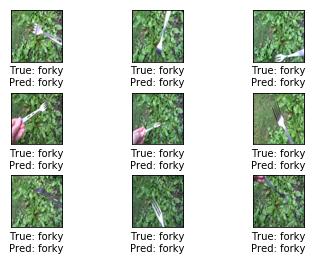

In [57]:
plot_images(images=some_images,
            cls_true=some_images_cls,
            cls_pred=cls_pred)

### Predictions for the Entire Test-Set

To get the predicted classes for the entire test-set, we just use its input-function:

In [58]:
predictions = model.predict(input_fn=test_input_fn)

In [59]:
cls_pred = np.array(list(predictions))
cls_pred

INFO:tensorflow:Restoring parameters from ./checkpoints_tutorial18-2/model.ckpt-200


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 2, 0, 0, 0, 2,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 2, 1, 0, 0, 2, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 1, 1, 0, 0, 0, 2,
       2, 0, 0, 2, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 2, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 2, 1, 0, 0, 1, 2, 0, 0, 1, 0, 1, 1, 0, 0, 0, 2, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       1, 2,

The Convolutional Neural Network predicts different classes for the images, although most have just been classified as 0 (forky), so the accuracy is horrible.

In [60]:
np.sum(cls_pred == 0)

333

In [61]:
np.sum(cls_pred == 1)

144

In [62]:
np.sum(cls_pred == 2)

53

## Conclusion

This tutorial showed how to use TensorFlow's binary file-format TFRecords with the Dataset and Estimator APIs. This should simplify the process of training models with very large datasets while getting high usage of the GPU. However, the API could have been simpler in many ways.

## Exercises

These are a few suggestions for exercises that may help improve your skills with TensorFlow. It is important to get hands-on experience with TensorFlow in order to learn how to use it properly.

You may want to backup this Notebook before making any changes.

* Train the Convolutional Neural Network for much longer. Does it get any better at classifying the Knifey-Spoony dataset?
* Save the One-Hot-encoded label instead of the class-integer in the TFRecord and modify the rest of the code to use it.
* Make shards so you save multiple TFRecord files instead of just one.
* Save jpeg-files in the TFRecord instead of the decoded image. You will then need to decode the jpeg-image in the `parse()` function. What are the pro's and con's of doing this?
* Try using another dataset.
* Use a dataset where the images are different sizes. Would you resize before or after converting to the TFRecords file? Why?
* Try and use numpy input-functions instead of TFRecords for the Estimator API. What is the performance difference?
* Explain to a friend how the program works.

## License (MIT)

Copyright (c) 2016-2017 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.